### __Import Libraries__

In [1]:
import numpy as np
import pandas as pd
import os
import random
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn import model_selection
#from sklearn.decomposition import PCA

### __Load Images__

In [2]:
def get_images(dir_):
    images = []
    for subdir, dirs, files in os.walk(dir_):
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(subdir, file))

    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))

#### Non-vehicle images

In [3]:
non_vehicles = get_images('non-vehicles/non-vehicles')
num_nonvehicles = len(non_vehicles)

In [4]:
print(len(non_vehicles))
print(non_vehicles[0].shape)

8968
(64, 64, 3)


#### Vehicle images

In [5]:
vehicles = get_images('vehicles/vehicles')
num_vehicles = len(vehicles)

In [6]:
print(len(vehicles))
print(vehicles[0].shape)

8792
(64, 64, 3)


### __Histogram of Gradients__

In [7]:
def get_Hog_features(img, pix_per_cell = (10,10), cell_per_block = (2,2), visaulize=True):

    features = []

    if visaulize is True:
        fd, hog_img = hog(img, orientations=8, pixels_per_cell=pix_per_cell,
                    cells_per_block=cell_per_block, visualize=visaulize,  multichannel =True)
        fd2, hog_img2 = hog(img, orientations=1, pixels_per_cell=pix_per_cell,
                    cells_per_block=cell_per_block, visualize=visaulize,  multichannel =True)
        features.append(fd2)
        features.append(fd)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

        ax1.imshow(img, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        
        hog_image_rescaled2 = exposure.rescale_intensity(hog_img2, in_range=(0, 10))
        ax3.imshow(hog_image_rescaled2, cmap=plt.cm.gray)
        ax3.set_title('X-Gradients')
        
        plt.show()
        
    else:
        features.append(hog(img, orientations=1, pixels_per_cell=pix_per_cell,
                    cells_per_block=cell_per_block, visualize=visaulize,  multichannel =True))
        features.append(hog(img, orientations=8, pixels_per_cell=pix_per_cell,
                    cells_per_block=cell_per_block, visualize=visaulize,  multichannel =True))
        
    return np.concatenate(features)

#### An Example of Vehicle images

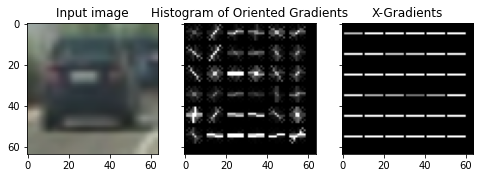

In [8]:
features_v = get_Hog_features(vehicles[0])

#### An Example of Non-vehicle images

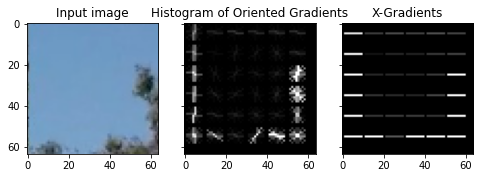

In [9]:
features_n = get_Hog_features(non_vehicles[0])

In [37]:
print('number of features :',len(features_n))

number of features : 900


In [11]:
x = pd.DataFrame(columns=range(len(features_n)), dtype = 'float64')
for v in vehicles:
    x.loc[len(x)] = get_Hog_features(v, visaulize=False)
for n in non_vehicles:
    x.loc[len(x)] = get_Hog_features(n, visaulize=False)

In [12]:
#pca = PCA(.99)
#pca.fit(features)
#features = pca.transform(features)

In [15]:
y = pd.Series(np.concatenate((np.ones(num_vehicles), np.zeros(num_nonvehicles))))
print(np.ones(len(vehicles)))
print(np.zeros(len(non_vehicles)))
print(len(y))
x.head()

[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]
17760


,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.500000,0.50000,0.50000,0.50000,0.5,0.5,0.5,0.5,0.5,0.5,...,0.016176,0.009758,0.039741,0.339984,0.330494,0.339984,0.312979,0.057638,0.026829,0.003045
1,0.500000,0.50000,0.50000,0.50000,0.5,0.5,0.5,0.5,0.5,0.5,...,0.034019,0.019386,0.198976,0.383449,0.266627,0.023477,0.053913,0.008721,0.016300,0.028627
2,0.500000,0.50000,0.50000,0.50000,0.5,0.5,0.5,0.5,0.5,0.5,...,0.062943,0.043613,0.097791,0.049570,0.058765,0.402666,0.171444,0.114321,0.205308,0.395089
3,0.491595,0.50277,0.50277,0.50277,0.5,0.5,0.5,0.5,0.5,0.5,...,0.006461,0.000000,0.114724,0.064816,0.068668,0.202265,0.355805,0.066825,0.167253,0.106311
4,0.500000,0.50000,0.50000,0.50000,0.5,0.5,0.5,0.5,0.5,0.5,...,0.042677,0.060568,0.348130,0.072652,0.090296,0.112291,0.102928,0.009114,0.055037,0.348130


### __Split Training/Test__

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x,y , test_size=0.2, train_size=0.8, random_state=42)
print(len(x_train), len(x_test))

14208 3552


### __Training the Classifier__

In [35]:
svc = LinearSVC(C=0.1)
svc.fit(x_train, y_train)

LinearSVC(C=0.1)

### __Evaluate the Classifier__

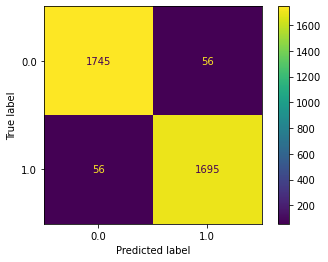

true negative 1745
false positive 56
false negative 56
true positive 1695
False Positive Rate = 0.031093836757357024


In [36]:
predicted = pd.Series(svc.predict(x_test), index=x_test.index)
indices = predicted[predicted ==1 ].index.tolist()

result = []
for i in indices:
    image = vehicles[0]
    if i < num_vehicles:
        image = vehicles[i]
    if i >= num_vehicles:
        image = non_vehicles[i - num_vehicles]
    
    # Threshold for color intensity in the image. But doesn't affect to result.
    #green (36,25,25), (86,255,255)
    #black (0,0,0), (255,255,0)
    #white (0,0,200), (180,255,255)
    #blue (100,150,0), (140,255,255)
    #yellow (20,100,100), (30,255,255)
    
    #green = cv2.inRange(cv2.cvtColor(image, cv2.COLOR_BGR2HSV), (36,25,25), (86,255,255))
    #g_ratio = len(image[green>0])/(len(image)*len(image))
    
    #if g_ratio > 0.7:
    #    print(g_ratio)
    #    result.append(i)
    #    plt.imshow(image, cmap=plt.cm.gray)
    #    plt.show()
        
#predicted.loc[result] = 0

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
plt.show()
tn, fp, fn, tp = cm.ravel()
print('true negative', tn)
print('false positive', fp)
print('false negative', fn)
print('true positive', tp)

print('False Positive Rate =', fp/(fp+tn))

In [39]:
print('Accuracy :', round(accuracy_score(y_test, predicted), 4))

Accuracy : 0.9685


### __False Positive images__

[10712, 10950, 12171, 10384, 11415, 15584, 9730, 10959, 12958, 10898, 12955, 13150, 10818, 15809, 11925, 10786, 15535, 12804, 11007, 13033, 11056, 10624, 14431, 17277, 15808, 13290, 16177, 9835, 15827, 16275, 15914, 12802, 10881, 15967, 15929, 10926, 10360, 16152, 10564, 12035, 13034, 10730, 11090, 11352, 15449, 10796, 11135, 9402, 16260, 14028, 11398, 13433, 13134, 14393, 10882, 10007]
1920


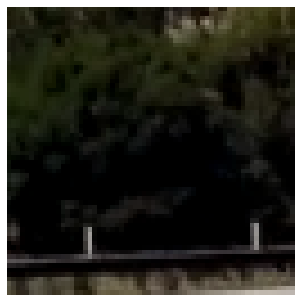

2158


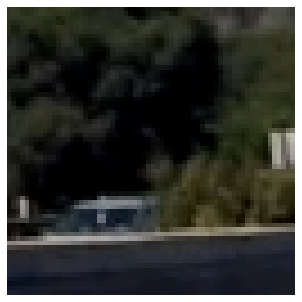

3379


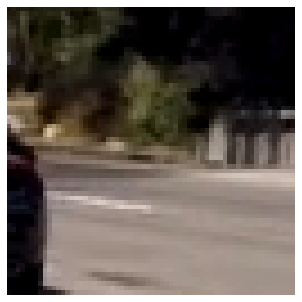

1592


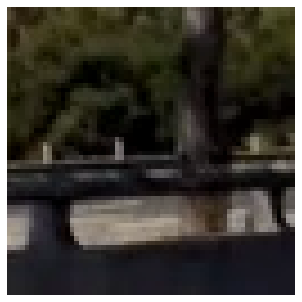

2623


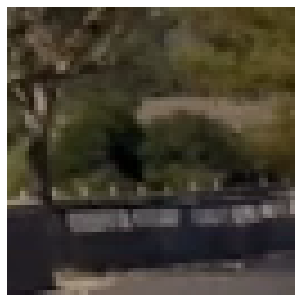

6792


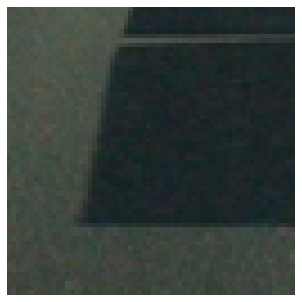

938


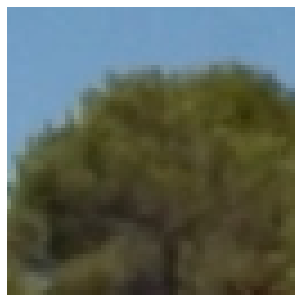

2167


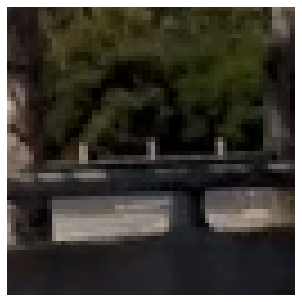

4166


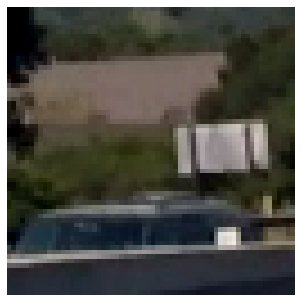

2106


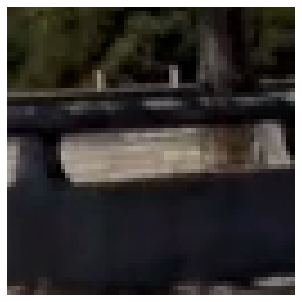

4163


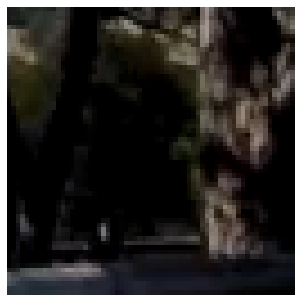

4358


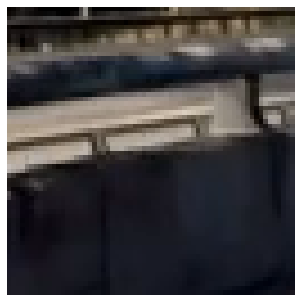

2026


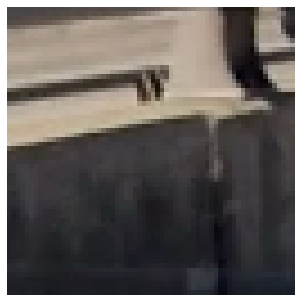

7017


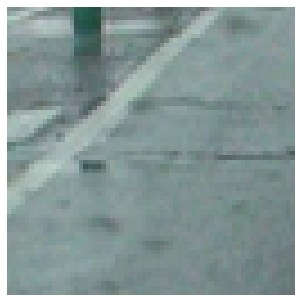

3133


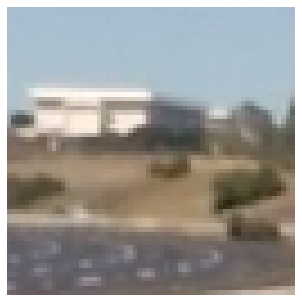

1994


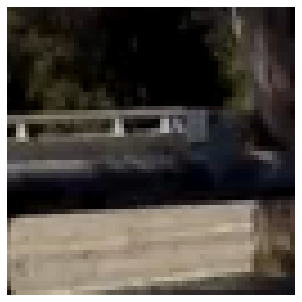

6743


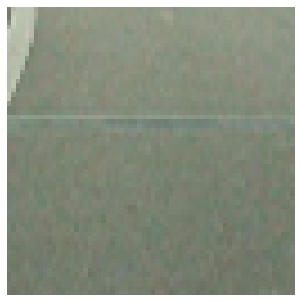

4012


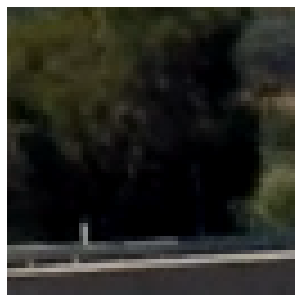

2215


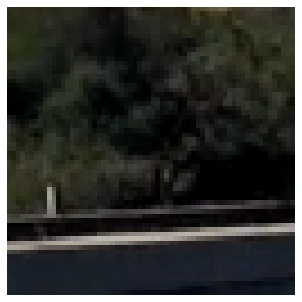

4241


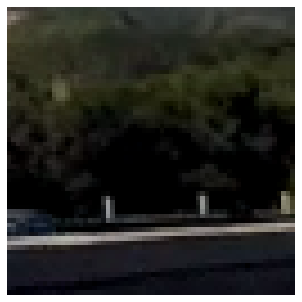

2264


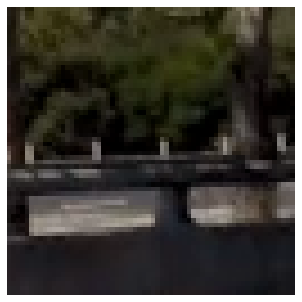

1832


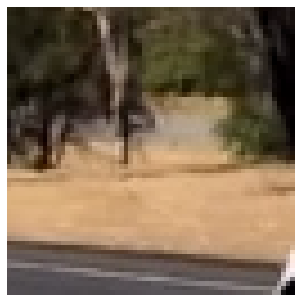

5639


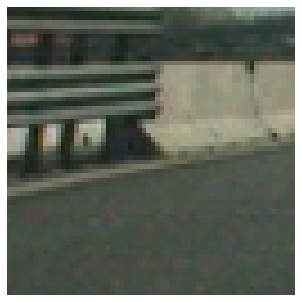

8485


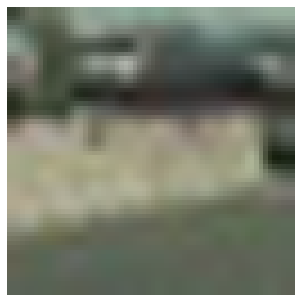

7016


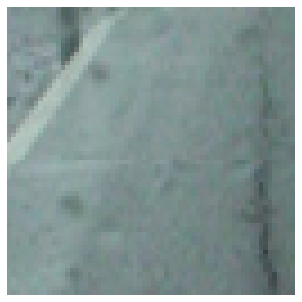

4498


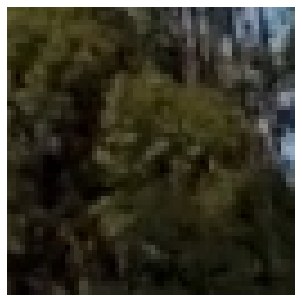

7385


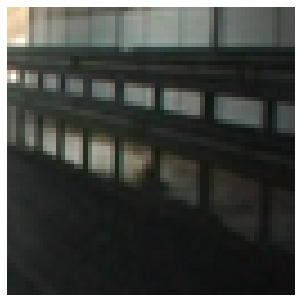

1043


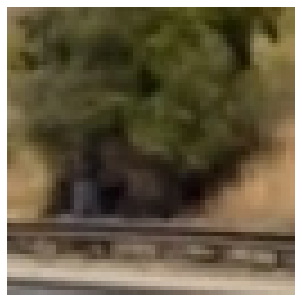

7035


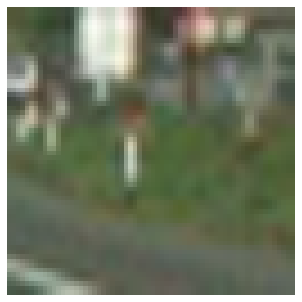

7483


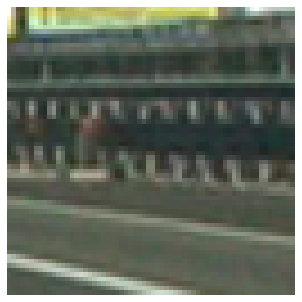

7122


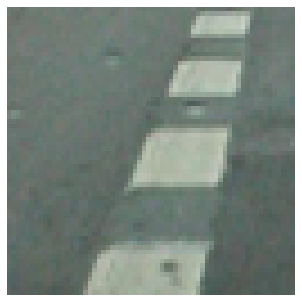

4010


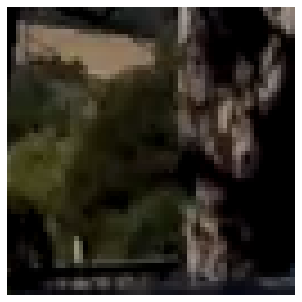

2089


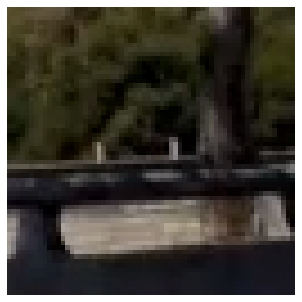

7175


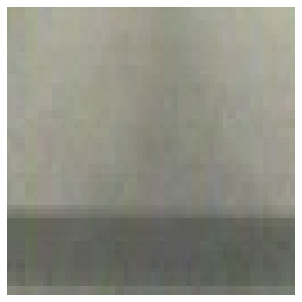

7137


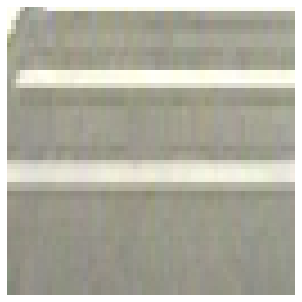

2134


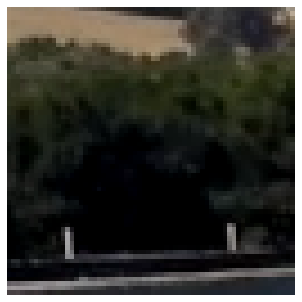

1568


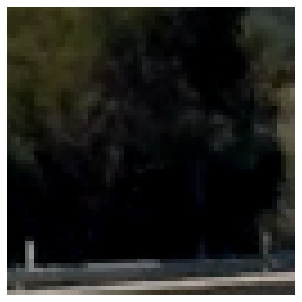

7360


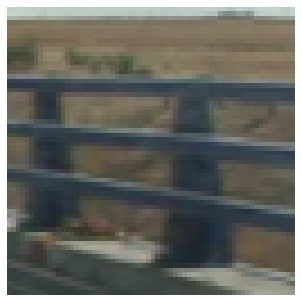

1772


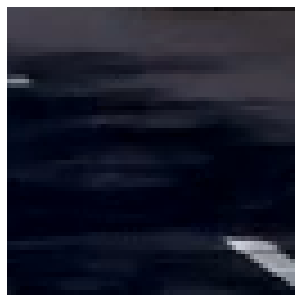

3243


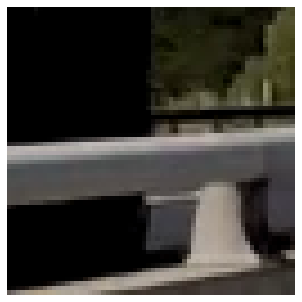

4242


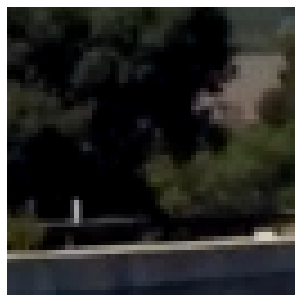

1938


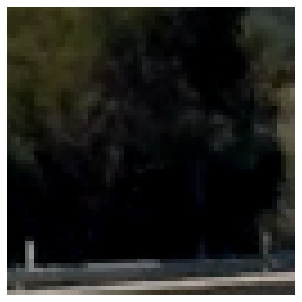

2298


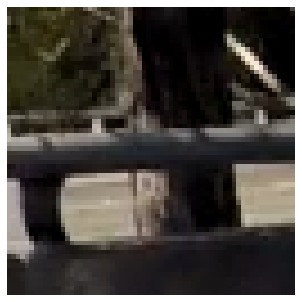

2560


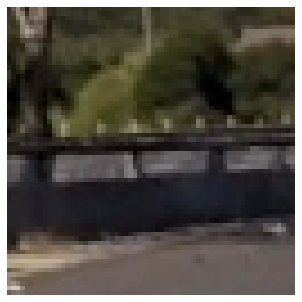

6657


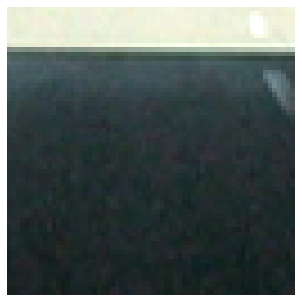

2004


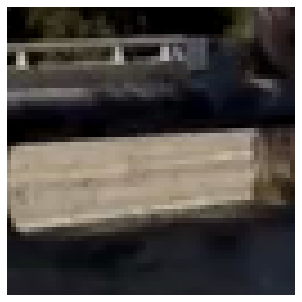

2343


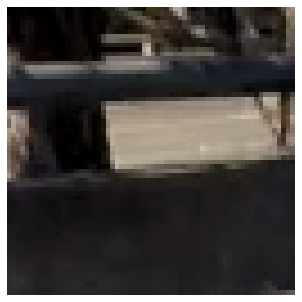

610


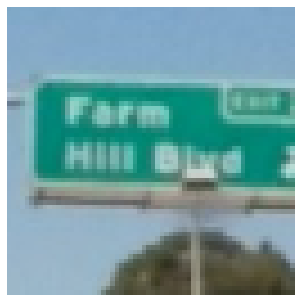

7468


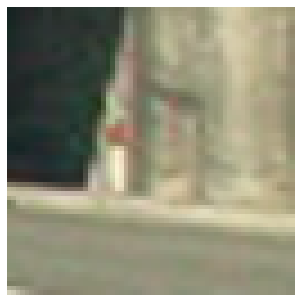

5236


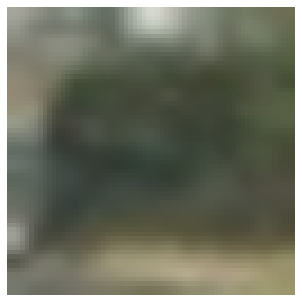

2606


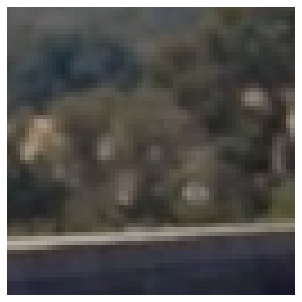

4641


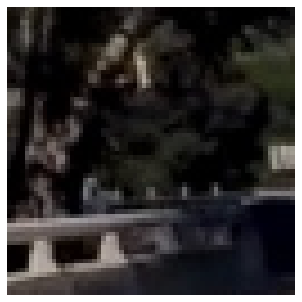

4342


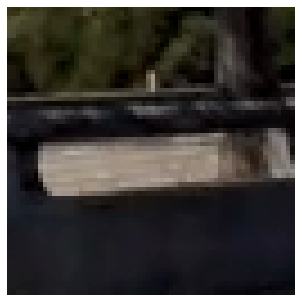

5601


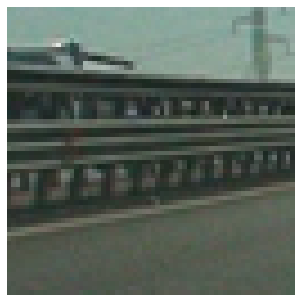

2090


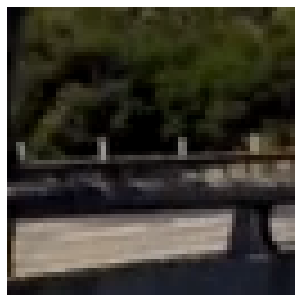

1215


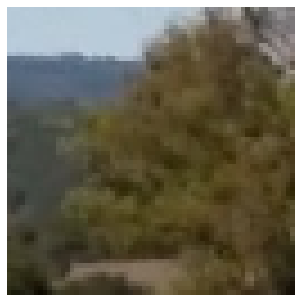

In [40]:
com = predicted.compare(y_test)
false_positive = com[com['self']==1].index.tolist()
print(false_positive)

for i in false_positive:
    print(i-num_vehicles)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    #plt.axis("off")
    plt.imshow(non_vehicles[i-num_vehicles])
    plt.show()